In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# qcdenoise imports
from qcdenoise import DenseModel, AdjTModel, AdjTAsymModel 
from qcdenoise.io_utils import QCIRCDataSet
from qcdenoise.ml_utils import train, test

#### Load Data

In [2]:
data_path = 'data/GraphState_nqbits9_UnitaryNoise_032920'
traindata = QCIRCDataSet('%s_train.lmdb' % data_path, debug=False)
testdata = QCIRCDataSet('%s_test.lmdb' % data_path, debug=False)
print('Total # of samples in train set: {}, test set:{}'.format(len(traindata), len(testdata)))
trainloader = DataLoader(traindata, batch_size=64, shuffle=True, pin_memory=True, drop_last=True)
testloader = DataLoader(testdata, batch_size=64, shuffle=True, pin_memory=True, drop_last=True)

Total # of samples in train set: 1140000, test set:76000


In [3]:
if not os.path.exists(data_path):
    os.mkdir(data_path)

#### initiate model

Text(0.5, 1.0, 'Adjacency Tensor')

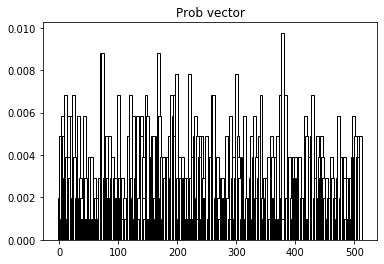

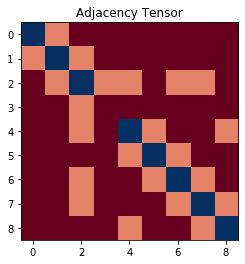

In [4]:
idx = np.random.randint(0, len(traindata)-1)
inputs, targets, encodings =  traindata[idx]['input'], traindata[idx]['target'], traindata[idx]['encoding']
inputs_dim = inputs.shape[0]
targets_dim = targets.shape[0]
encodings_dim = encodings.shape
plt.figure(1)
plt.bar(np.arange(inputs_dim), inputs.numpy(), width=5, color='w', edgecolor='k')
plt.title("Prob vector")
plt.figure(2)
plt.imshow(encodings.numpy()[0], cmap='RdBu')
plt.title("Adjacency Tensor")

In [5]:
inputs_dim = inputs.shape[0]
targets_dim = targets.shape[0]
encodings_dim = encodings.shape
net_res = AdjTAsymModel(inputs_dim=inputs_dim, targets_dim=targets_dim, encodings_dim=encodings_dim, 
                                  combine_mode='Multiply', asym_mode='residual')
# print('AdjNet (Residual Units):\n', net_res)
net_dense = AdjTAsymModel(inputs_dim=inputs_dim, targets_dim=targets_dim, encodings_dim=encodings_dim, 
                                  combine_mode='Multiply', asym_mode='dense')
# print('AdjNet (Dense Units):\n',net_dense)

### Train

#### loss functions

In [6]:
def mse(outputs, targets):
    MSE = torch.nn.MSELoss(reduction='sum')
    outputs = F.softmax(outputs, dim=1)
    return MSE(outputs, targets)

def kl(outputs, targets):
    KL = torch.nn.KLDivLoss(reduction='sum')
    outputs = F.log_softmax(outputs, dim=1)
    return KL(outputs, targets)

#### Optimizer/Learning policy

In [7]:
def exp_scheduler(net, ilr=1e-3, lr_decay=0.9, weight_decay=1e-4):
    ilr = 1e-3
    optimizer = optim.Adam(net.parameters(), lr=ilr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
    return scheduler, optimizer


#### Dense Block 

In [7]:
loss_func = kl
test_func_args = (net_dense, testloader, loss_func)
train(net_dense, trainloader, loss_func, lr=1e-3, batch_log=250, num_epochs=50, test_epoch=2, test_func_args=test_func_args)

TypeError: train_adjT() missing 2 required positional arguments: 'scheduler' and 'optimizer'

#### Residual Block 

In [ ]:
model_path = os.path.join(data_path,'residual_model.pt')
loss_func = kl
scheduler, optimizer = exp_scheduler(net_res)
test_func_args = (net_res, testloader, loss_func)
train(net_res, trainloader, loss_func, scheduler, optimizer, save_epoch=1, lr=1e-3, 
      batch_log= 250, num_epochs=100, test_epoch=2, test_func_args=test_func_args, path=model_path)

Epoch=1, Lr= 0.000900, Batch=  250, Loss=8.867
Epoch=1, Lr= 0.000900, Batch=  500, Loss=8.764
Epoch=1, Lr= 0.000900, Batch=  750, Loss=8.669
Epoch=1, Lr= 0.000900, Batch= 1000, Loss=8.394
Epoch=1, Lr= 0.000900, Batch= 1250, Loss=8.713
Epoch=1, Lr= 0.000900, Batch= 1500, Loss=8.665
Epoch=1, Lr= 0.000900, Batch= 1750, Loss=8.404
Epoch=1, Lr= 0.000900, Batch= 2000, Loss=8.986
Epoch=1, Lr= 0.000900, Batch= 2250, Loss=8.585
Epoch=1, Lr= 0.000900, Batch= 2500, Loss=8.352
Epoch=1, Lr= 0.000900, Batch= 2750, Loss=8.570
Epoch=1, Lr= 0.000900, Batch= 3000, Loss=8.580
Epoch=1, Lr= 0.000900, Batch= 3250, Loss=8.208
Epoch=1, Lr= 0.000900, Batch= 3500, Loss=8.456
Epoch=1, Lr= 0.000900, Batch= 3750, Loss=8.444
Epoch=1, Lr= 0.000900, Batch= 4000, Loss=8.530
Epoch=1, Lr= 0.000900, Batch= 4250, Loss=8.303
Epoch=1, Lr= 0.000900, Batch= 4500, Loss=8.286
Epoch=1, Lr= 0.000900, Batch= 4750, Loss=8.373
Epoch=1, Lr= 0.000900, Batch= 5000, Loss=8.082
Epoch=1, Lr= 0.000900, Batch= 5250, Loss=8.074
Epoch=1, Lr= 

#### Load Trained Model from checkpoint

In [18]:
model_path = os.path.join(data_path,'residual_model.pt')
net_res = AdjTAsymModel(inputs_dim=inputs_dim, targets_dim=targets_dim, encodings_dim=encodings_dim, 
                        combine_mode='Multiply', asym_mode='residual')
net_res.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Test

In [19]:
test(net_res, testloader, kl)
# test(net_dense, testloader, kl)

Batches=1187, Average Loss= 16.542


sample=26572


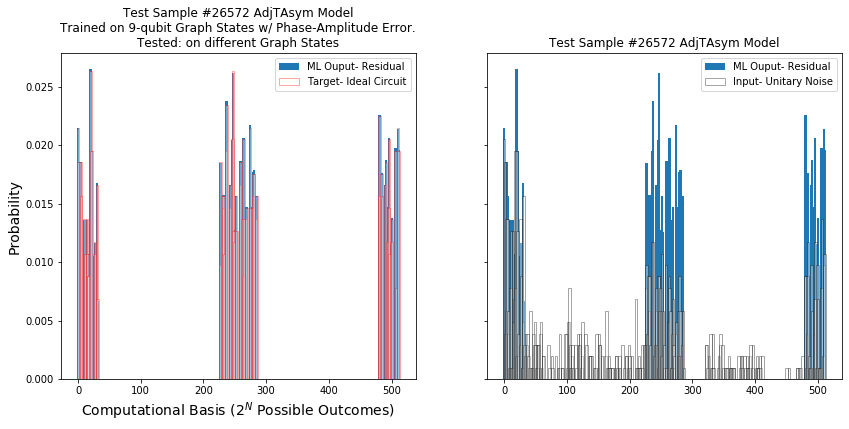

In [24]:
idx = np.random.randint(0, len(testdata)-1)
print('sample=%d'%idx)
inputs, targets, encodings = testdata[idx]['input'], testdata[idx]['target'], testdata[idx]['encoding']
with torch.no_grad():
#     net = net_dense.to('cpu')
#     net.eval()
    inputs = torch.unsqueeze(inputs,0)
    encodings = torch.unsqueeze(encodings, 0)
#     outputs_dense = net(inputs, encodings)
#     outputs_dense = F.softmax(outputs_dense)
    net = net_res.to('cpu')
    net.eval()
    outputs_res = net(inputs, encodings)
    outputs_res = F.softmax(outputs_res)
fig,axes = plt.subplots(1,2,figsize=(14,6), sharex=True, sharey=True)
# ax.plot(np.squeeze(outputs.numpy()), label='Ouput', marker='s')
# ax.plot(np.squeeze(outputs_dense.numpy()), label='Ouput- dense', marker='o')
axes[0].bar(np.arange(inputs_dim), np.squeeze(outputs_res.numpy()), width=4, label='ML Ouput- Residual')
axes[0].bar(np.arange(inputs_dim), np.squeeze(targets.numpy()), width=4, label='Target- Ideal Circuit', color='w', edgecolor='r', alpha=0.35)
axes[1].bar(np.arange(inputs_dim), np.squeeze(outputs_res.numpy()), width=4, label='ML Ouput- Residual')
axes[1].bar(np.arange(inputs_dim), np.squeeze(inputs.numpy()), width=4, label='Input- Unitary Noise', color='w', edgecolor='k', alpha=0.35)
# axes[0].set_title('Test Sample #%d' %idx, fontsize=12)
axes[0].set_title('Test Sample #%d AdjTAsym Model\nTrained on 9-qubit Graph States w/ Phase-Amplitude Error.\n'\
             'Tested: on different Graph States'%idx, fontsize=12)
axes[1].set_title('Test Sample #%d AdjTAsym Model' %idx, fontsize=12)
axes[0].set_xlabel("Computational Basis ($2^N$ Possible Outcomes)", fontsize=14)
axes[0].set_ylabel("Probability", fontsize=14)
axes[0].legend()
axes[1].legend()

In [179]:
fig.savefig("graphstate_nqubits9_032820_unitarynoise_residual.png", dpi=300)

sample=5883


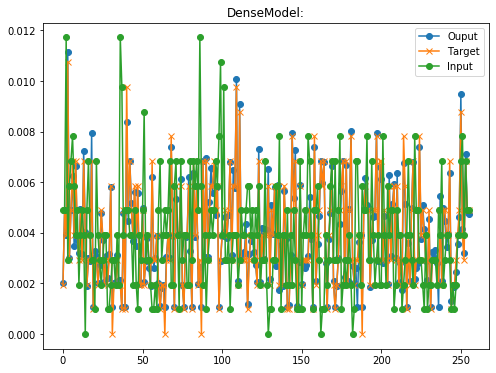

In [28]:
idx = np.random.randint(0, len(testdata)-1)
print('sample=%d'%idx)
inputs, targets, encodings = testdata[idx]['input'], testdata[idx]['target'], testdata[idx]['encoding']
with torch.no_grad():
    net = net_dense.to('cpu')
    inputs = torch.unsqueeze(inputs,0)
    encodings = torch.unsqueeze(encodings, 0)
    outputs = net(inputs, encodings)
fig,ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(np.squeeze(outputs.numpy()), label='Ouput', marker='o')
ax.plot(np.squeeze(targets.numpy()), label='Target', marker='x')
ax.plot(np.squeeze(inputs.numpy()), label='Input', marker='o')
ax.set_title('DenseModel:')
ax.legend()